In [1]:
import os
import sys
import math
import time
import queue
import random
import shutil
import logging
import operator
import threading
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from typing import TypeAlias, Iterator, Generator, Union, NamedTuple, Callable, Dict
from pathlib import Path

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
# import torch._dynamo; torch._dynamo.config.suppress_errors = True

In [2]:
# 1. CONFIGURATION

# --- Data Configuration ---
DATASET_PATH = Path(r"F:\deep_experiments\datasets\CIFAR10_data")
BATCH_SIZE = 512
N_CLASSES = 10

# --- Device Configuration ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

torch.backends.cuda.matmul.allow_tf32 = True  # Allow TF32 on matmul
torch.backends.cudnn.allow_tf32 = True  # Allow TF32 on cudnn
torch.backends.cudnn.benchmark = True  # Enable cudnn autotuner
torch._C._jit_set_profiling_executor(True)
torch._C._jit_set_profiling_mode(True)

Using device: cuda


True

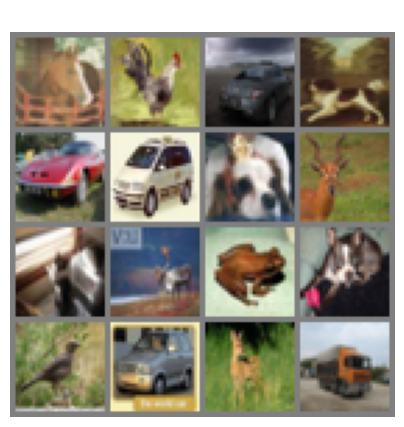

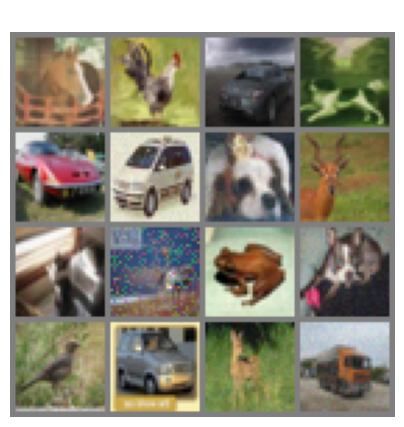

Demonstration complete. Original and augmented image grids have been displayed.


In [ ]:
# --- Augmentation Functions ---

def identity(images: torch.Tensor) -> torch.Tensor:
    """Returns the original images, unchanged."""
    return images

def random_horizontal_flip(images: torch.Tensor) -> torch.Tensor:
    """Flips images horizontally with a 50% probability."""
    if random.random() < 0.5:
        return torch.flip(images, dims=[3])
    return images

def add_normal_noise(images: torch.Tensor, noise_scale: float = 0.04) -> torch.Tensor:
    """Adds Gaussian noise to images."""
    noise = torch.randn_like(images)
    noise = noise - noise.min()
    noise = noise / noise.max()
    image = (1.0 - noise_scale) * images + noise_scale * noise
    return image

def add_uniform_noise(images: torch.Tensor, noise_scale: float = 0.05) -> torch.Tensor:
    """Adds uniform noise to images."""
    return (1.0 - noise_scale) * images + noise_scale * torch.rand_like(images)

def bernoulli_2Dmask(images: torch.Tensor, keep_prob: float = 0.8) -> torch.Tensor:
    """Applies a random binary mask to images, setting some pixels to 0."""
    print("compiling bernoulli_2Dmask")
    mask = torch.bernoulli(keep_prob, shape=images.shape[-2:])
    return images * mask

def bernoulli_3Dmask(images: torch.Tensor, keep_prob: float = 0.95) -> torch.Tensor:
    """Applies a random binary mask to images, setting some pixels to 0."""
    print("compiling bernoulli_3Dmask")
    mask = torch.bernoulli(keep_prob, shape=images.shape)
    return images * mask

def color_channel_flip(images: torch.Tensor) -> torch.Tensor:
    """Applies a single, random permutation of color channels to a batch of images."""
    # Note: This applies the *same* permutation to all images in the batch.
    permutation = torch.randperm(3)
    return images[:, permutation, :, :]

# --- Augmentation Pipeline Configuration ---
# Based on the logic from the original code, the effective probabilities for each
# distinct transformation have been calculated and are defined explicitly here.
# This makes the configuration much clearer and easier to modify.

# Original logic breakdown:
# Prob(Noise) = 0.6 * 0.8 = 0.48
# Prob(Color Flip) = 0.6 * 0.15 = 0.09
# Prob(K-Means Placeholder) = 0.6 * 0.05 = 0.03
# Prob(Identity) = 0.4
#
# The K-Means and Identity options both used a function that performed a 50/50
# horizontal flip or true identity. Total prob for this function = 0.03 + 0.40 = 0.43.
#
# Final calculated probabilities:
# - Normal Noise: 0.48 * 0.7 = 0.336
# - Uniform Noise: 0.48 * 0.2 = 0.096
# - Bernoulli Mask: 0.48 * 0.1 = 0.048
# - Color Flip: 0.09
# - Horizontal Flip: 0.43 * 0.5 = 0.215
# - True Identity: 0.43 * 0.5 = 0.215
# Sum: 0.336 + 0.096 + 0.048 + 0.09 + 0.215 + 0.215 = 1.0

AUGMENTATION_PIPELINE: Dict[Callable[[torch.Tensor], torch.Tensor], float] = {
    add_normal_noise: 0.336,
    add_uniform_noise: 0.096,
    bernoulli_2Dmask: 0.048,
    bernoulli_3Dmask: 0.01,
    color_channel_flip: 0.09,
    random_horizontal_flip: 0.21,
    identity: 0.21,  # Note: K-Means is not implemented and its probability
                      # is absorbed into the identity/flip operations as in the original.
}

# Verify that probabilities sum to 1.0
assert math.isclose(sum(AUGMENTATION_PIPELINE.values()), 1.0), "Probabilities must sum to 1.0"


# 2. DATA LOADING

# Define the transformation to normalize images into the range [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create the dataset path if it doesn't exist
DATASET_PATH.mkdir(parents=True, exist_ok=True)

# Load CIFAR-10 datasets
train_dataset = datasets.CIFAR10(root=DATASET_PATH, train=True, download=False, transform=transform)
test_dataset = datasets.CIFAR10(root=DATASET_PATH, train=False, download=False, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

get_labels = lambda data_loader: [l for batch in data_loader for l in  batch[1].numpy().tolist()]

train_labels = np.array(get_labels(train_loader))
test_labels = np.array(get_labels(test_loader))

def augment_image_batch(
    images: torch.Tensor,
    augmentations: Dict[Callable[[torch.Tensor], torch.Tensor], float]
) -> torch.Tensor:
    """
    Applies a random augmentation from the provided pipeline to each image in a batch.

    This version is robust and efficient, using boolean masking to apply transformations
    to relevant subsets of the image batch, avoiding complex and potentially buggy sorting.

    Args:
        images: A batch of images as a PyTorch tensor (B, C, H, W).
        augmentations: A dictionary mapping augmentation functions to their probabilities.

    Returns:
        A new tensor containing the augmented images.
    """
    aug_fns = list(augmentations.keys())
    probs = list(augmentations.values())
    
    # For each image in the batch, choose an augmentation function index based on probability
    B, C, H, W = images.shape
    choices = np.random.choice(len(aug_fns), size=(B,), p=probs)
    
    # Create an output tensor to store augmented images
    output_images = torch.empty_like(images)

    # Apply the chosen augmentation for each group of images that share the same choice
    for i, func in enumerate(aug_fns):
        # Create a boolean mask for the images that need this augmentation
        mask = (choices == i)
        
        # If any image was chosen for this augmentation, apply the function
        if mask.any():
            output_images[mask] = func(images[mask])
            
    return output_images


# 4. DEMONSTRATION

def imshow(img_tensor: torch.Tensor, title: str):
    """Helper function to un-normalize and display an image tensor."""
    img_tensor = img_tensor / 2 + 0.5  # Un-normalize from [-1, 1] to [0, 1]
    npimg = img_tensor.numpy()
    plt.figure(figsize=(5, 5), frameon=False)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# --- Fetch a batch of original images ---
original_images, _ = next(iter(train_loader))

# --- Apply the new augmentation pipeline ---
augmented_images = augment_image_batch(original_images, AUGMENTATION_PIPELINE)

# --- Display the results ---
# Show a grid of the first 16 original images
imshow(make_grid(original_images[:16], nrow=4), "Original Images")

# Show a grid of the first 16 augmented images
imshow(make_grid(augmented_images[:16], nrow=4), "Augmented Images")

plt.figure(figsize=(4, 2), frameon=False); plt.hist(train_labels, rwidth=.5); plt.show()
plt.figure(figsize=(4, 2), frameon=False); plt.hist(test_labels,  rwidth=.5); plt.show()
print("Demonstration complete. Original and augmented image grids have been displayed.")

### Model and Modual Definition

In [ ]:
class Attention(nn.Module):
    """Standard Multi-Head Attention using PyTorch's efficient implementation."""
    def __init__(self, dim: int, num_heads: int, qkv_bias: bool = False):
        super().__init__()
        assert dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        # Fused QKV projection
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        # Output projection
        self.proj = nn.Linear(dim, dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, N, C = x.shape
        # Project to Q, K, V and reshape for multi-head attention
        # (B, N, 3 * D) -> (B, N, 3, H, D_h) -> (3, B, H, N, D_h)
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0) # Unbind along the first dimension

        # Use PyTorch 2.0's efficient attention
        # For older PyTorch, you'd do: (q @ k.transpose(-2, -1)) * self.scale
        # followed by softmax and matmul with v.
        attn_output = F.scaled_dot_product_attention(q, k, v)

        # Reshape and project back to original dimension
        # (B, H, N, D_h) -> (B, N, H, D_h) -> (B, N, D)
        out = attn_output.transpose(1, 2).reshape(B, N, C)
        out = self.proj(out)
        return out

class FeedForward(nn.Module):
    """Standard Feed-Forward Network found in Transformers."""
    def __init__(self, dim: int, hidden_dim: int, dropout: float = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(), # GELU is standard in ViT
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class GLU(nn.Module):
    """Gated Linear Unit variant: Sigmoid(W_gate*x) * (W_transform*x)."""
    def __init__(self, in_features: int, hidden_dim: int, out_features: int, dropout: float = 0.5, bias: bool = False):
        super().__init__()
        # Linear layer for gate and value, then split. hidden_features is for each branch before *
        self.fc_gate_value = nn.Linear(in_features, 2 * hidden_dim, bias=bias)
        self.fc_out = nn.Linear(hidden_dim, out_features, bias=bias)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        gate_val_proj: torch.Tensor = self.fc_gate_value(x)
        # Split into two parts: one for the gate, one for the value
        gated_values, gate_input = torch.split(gate_val_proj, gate_val_proj.shape[-1] // 2, dim=-1)

        gated_activation = self.dropout(self.sigmoid(gated_values) * gate_input) # Element-wise product
        out = self.fc_out(gated_activation)
        return out

class TransformerBlock(nn.Module):
    """A single Transformer Block."""
    def __init__(self, dim: int, num_heads: int, mlp_ratio: float = 4.0, qkv_bias: bool = False, dropout: float = 0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads, qkv_bias)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = GLU(in_features=dim, hidden_dim=int(dim * mlp_ratio), out_features=dim, dropout=dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Pre-normalization is a common and stable variant
        x = x + self.attn(self.norm1(x))
        x = x + self.ffn(self.norm2(x))
        return x

image_shape: TypeAlias = tuple[int, int, int]

class ViT(nn.Module):
    """
    Vision Transformer with a CNN-based patchifier (Hybrid ViT).
    """
    def __init__(
            self,
            *,
            img_shape: image_shape,
            patch_size: int = 4, # The size of patches to be extracted from the feature map
            num_classes: int,
            dim: int,
            depth: int,
            heads: int,
            mlp_ratio: float = 4.0,
            channels: int = 3,
            dropout: float = 0.1
            ):
        super().__init__()
        
        # 1. CNN Feature Extractor (Patchifier)
        # This block correctly downsamples the image.
        # Input: 32x32x3 -> Conv -> 32x32x16 -> Pool -> 16x16x16 -> Conv -> 16x16x32 -> Pool -> 8x8x32
        self.conv_patchifier = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1), # 32 -> 32
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1), # 32 -> 32
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1), # 32 -> 16
            nn.Conv2d(32, dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 16 -> 8
        )
        img_size = np.array(img_shape[:-1]).prod()
        # After conv_patchifier, feature map is (dim, 8, 8)
        feature_map_size = img_size // 4**2 # two maxpools with stride 2
        assert feature_map_size == 64, f"Feature map size calculation is wrong. Expected 8 instead got {feature_map_size}"
        
        num_patches = (feature_map_size // patch_size) ** 2
        
        # This is an alternative, more direct way to patchify, but we use the CNN above
        # self.patch_embedding = nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size)
        
        # 2. Transformer specific parameters
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(dropout)
        
        # 3. Stack of Transformer Blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(dim=dim, num_heads=heads, mlp_ratio=mlp_ratio, dropout=dropout)
            for _ in range(depth)
        ])
        
        # 4. Classifier Head
        self.to_latent = nn.Identity()
        self.classifier_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img: torch.Tensor) -> torch.Tensor:
        # 1. Create patch embeddings using the CNN
        x = self.conv_patchifier(img) # Shape: (B, dim, H', W') -> (B, 64, 8, 8)
        # Flatten and transpose for transformer input
        x = x.flatten(2).transpose(1, 2) # Shape: (B, num_patches, dim) -> (B, 64, 64)
        B, N, _ = x.shape

        # 2. Prepend CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1) # Shape: (B, num_patches + 1, dim)
        
        # 3. Add positional embedding
        x += self.pos_embedding[:, :(N + 1)]
        x = self.dropout(x)
        
        # 4. Pass through transformer blocks
        for block in self.transformer_blocks:
            x = block(x)
            
        # 5. Get the CLS token output and classify
        cls_output = self.to_latent(x[:, 0])
        return self.classifier_head(cls_output)

In [4]:
def cos_anneal_lr_scheduler_gen(
    warmup_steps: int, total_anneal_steps: int, 
    lr_at_warmup_start: float, lr_at_cosine_start: float, lr_at_cosine_end: float
) -> Iterator[float]:
    """
    Generates learning rates: linear warmup then cosine annealing.  
    Note: total_anneal_steps is total_steps - warmup_steps
    """

    # Linear warmup phase
    for step in range(warmup_steps):
        progress = (step + 1) / warmup_steps
        current_lr = lr_at_warmup_start + progress * (lr_at_cosine_start - lr_at_warmup_start)
        yield current_lr

    # Cosine annealing phase
    for step in range(total_anneal_steps):
        cos_inner = math.pi * step / total_anneal_steps
        current_lr = lr_at_cosine_end + 0.5 * (lr_at_cosine_start - lr_at_cosine_end) * (1 + math.cos(cos_inner))
        yield current_lr

### Model & Optimizer Instantiation

In [ ]:
# --- Model Hyperparameters ---
model = ViT(
    img_shape=(32, 32, 3),
    patch_size=1, # After CNN, feature map is 8x8. We treat each 1x1 pixel as a "patch".
    num_classes=N_CLASSES,
    dim=32,       # Embedding dimension
    depth=6,      # Number of transformer blocks
    heads=8,      # Number of attention heads
    mlp_ratio=4,
    dropout=0.1
).to(device)

# Doesn't work on my GPU
# # Use torch.compile for a significant speedup on PyTorch 2.0+
# if hasattr(torch, 'compile'):
#     print("Compiling the model...")
#     model = torch.compile(model)

parameter_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {parameter_count:,}")
expected_untrained_loss = -math.log(1/N_CLASSES)
print(f"Expected untrained loss: {expected_untrained_loss:.4f}")

# --- Optimizer and Loss ---
NUM_EPOCHS = 40
num_batches = len(train_loader)
total_optim_steps = num_batches * NUM_EPOCHS
warmup_steps = int(0.1 * total_optim_steps)
total_anneal_steps = total_optim_steps - warmup_steps

lr_scheduler = cos_anneal_lr_scheduler_gen(
    warmup_steps=warmup_steps,
    total_anneal_steps=total_anneal_steps,
    lr_at_warmup_start=1e-5,
    lr_at_cosine_start=2e-3,
    lr_at_cosine_end=1e-5
)

loss_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.05) # Start LR is managed by scheduler

Using device: cuda
Number of trainable parameters: 235,882
Expected untrained loss: 2.3026


### History, Logging and Training Functions

In [ ]:
class History(NamedTuple):
    loss: list = []
    accuracy: list = []
    LR: list = []
    gradient_norm: list = []

    def __call__(self, loss:float, accuracy:float, lr:float, grad_norms:dict):
        self.loss.append(loss)
        self.accuracy.append(accuracy)
        self.LR.append(lr)
        self.gradient_norm.append(grad_norms)
        grad_norm_mean, grad_norm_std = summery_norm(grad_norms)
        list_to_fit = [
            f"Loss: {loss:.4f}",
            f"Acc: {accuracy:.4f}",
            f"LR: {lr:.6f}",
            f"grad norm mean: {grad_norm_mean:.3f}",
            f"grad norm std: {grad_norm_std:.3f}"]
        return " | ".join(list_to_fit)

history = History()

log_name = f"ViT_train_info_{dt.datetime.now().date().isoformat()}"
logger = logging.getLogger(log_name)
logging.basicConfig(filename=f'{log_name}.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', encoding='utf-8')

@torch.no_grad()
def per_layer_grad_norm(model:ViT) -> dict:
    return {k: torch.linalg.norm(v.grad).item() for k, v in list(model.named_parameters()) if hasattr(v, "requires_grad") and (v.requires_grad == True)}

def summery_norm(parameter_dict:dict):
    grad_norm = np.array([v for k, v in parameter_dict.items()])
    return grad_norm.mean(), grad_norm.std()

@torch.no_grad()
def accuracy(logits:torch.Tensor, targets:torch.Tensor, return_pred_class:bool=False) -> Union[tuple, float]:
    logits_argmax = logits.argmax(-1)
    mean_accuracy = (logits_argmax == targets).to(torch.float32).mean().item()
    out = (mean_accuracy, logits_argmax) if return_pred_class else mean_accuracy
    return out

def train_step(
        batch:tuple[torch.Tensor, torch.Tensor], 
        model:ViT, 
        criterion:nn.CrossEntropyLoss, 
        optimizer:torch.optim.AdamW, 
        lr_scheduler: Union[Generator, Iterator]):
    model.train()
    lr = next(lr_scheduler)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    inputs, targets = batch
    inputs, targets = augment_image_batch(inputs.to(device), AUGMENTATION_PIPELINE), targets.to(device)
    
    optimizer.zero_grad(set_to_none=True)
    logits = model(inputs)
    loss: torch.Tensor = criterion(logits, targets)
    acc = accuracy(logits, targets)
    loss.backward()
    
    optimizer.step()
    return history(loss.item(), acc, lr, per_layer_grad_norm(model)) # type: ignore # TODO: change grad norm argument


### TRAINING LOOP

In [7]:
print("Starting training...")
num_train_batches = len(train_loader)
for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()
    for batch_idx, batch in enumerate(train_loader):
        history_report = train_step(batch, model, loss_criterion, optimizer, lr_scheduler)

        if batch_idx % 10 == 0:
            reports = [
                f"\rEpoch: {round(epoch + (batch_idx/num_train_batches), 2):.2f}/{NUM_EPOCHS}",
                history_report
                ]
            logger.info(" -- ".join(reports))

        if batch_idx % 20 == 0:
            print(*reports, sep=' | ', end='', flush=True)

    Epoch_Report = [
        f"\r>>> Epoch {round(epoch + (batch_idx/num_train_batches))} complete.", 
        f"Epoch lasted {round(time.time() - epoch_start_time)} seconds <<<\n"]
    logger.info(" -- ".join(Epoch_Report))

print("\nTraining finished.")
# Save the model (use the compiled model if available)
torch.save(model.state_dict(), f"ViT_CIFAR10_{parameter_count:,}.pt")

Starting training...
Epoch: 39.82/40 | Loss: 0.9328 | Acc: 0.6602 | LR: 0.000010 | mean gradient norm: 0.110
Training finished.


In [ ]:
# --- EVALUATION ---
@torch.no_grad()
def evaluate(model, test_loader, criterion):
    model.eval()
    total_loss, total_acc, total_count = 0, 0, 0
    for batch in test_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        logits = model(inputs)
        loss = criterion(logits, targets)
        acc = accuracy(logits, targets)
        
        total_loss += loss.item() * len(inputs)
        total_acc += acc * len(inputs) # type: ignore
        total_count += len(inputs)
    
    avg_loss = total_loss / total_count
    avg_acc = total_acc / total_count
    return {"avg_loss": avg_loss, "avg_accuracy": avg_acc}

# To evaluate, load the state dict into a non-compiled model instance
eval_model = ViT(img_shape=(32, 32, 3), patch_size=1, num_classes=10, dim=32, depth=6, heads=8).to(device)
eval_model.load_state_dict(torch.load(f"ViT_CIFAR10_{parameter_count:,}.pt")) # ctrl c-v model name if loading later
eval_results = evaluate(eval_model, test_loader, loss_criterion)
print(f"Evaluation Results -> Avg Loss: {eval_results['avg_loss']:.4f}, Avg Accuracy: {eval_results['avg_accuracy']:.4f}")

Evaluation Results -> Avg Loss: 0.9309, Avg Accuracy: 0.6744


In [24]:
clean_dict = {}
for key in history.gradient_norm[0].keys():
    current_list = []
    for snap in history.gradient_norm:
        current_list.append(snap[key])
    clean_dict[key] = current_list

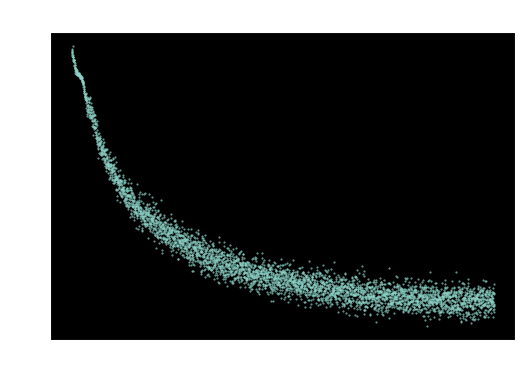

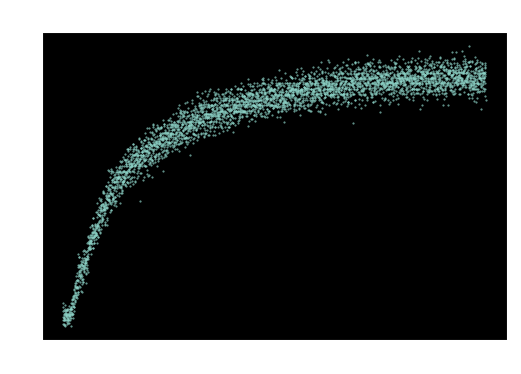

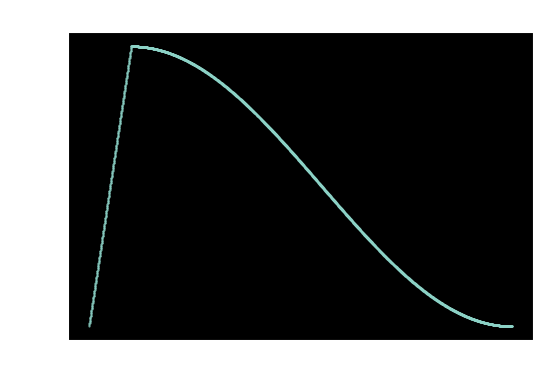

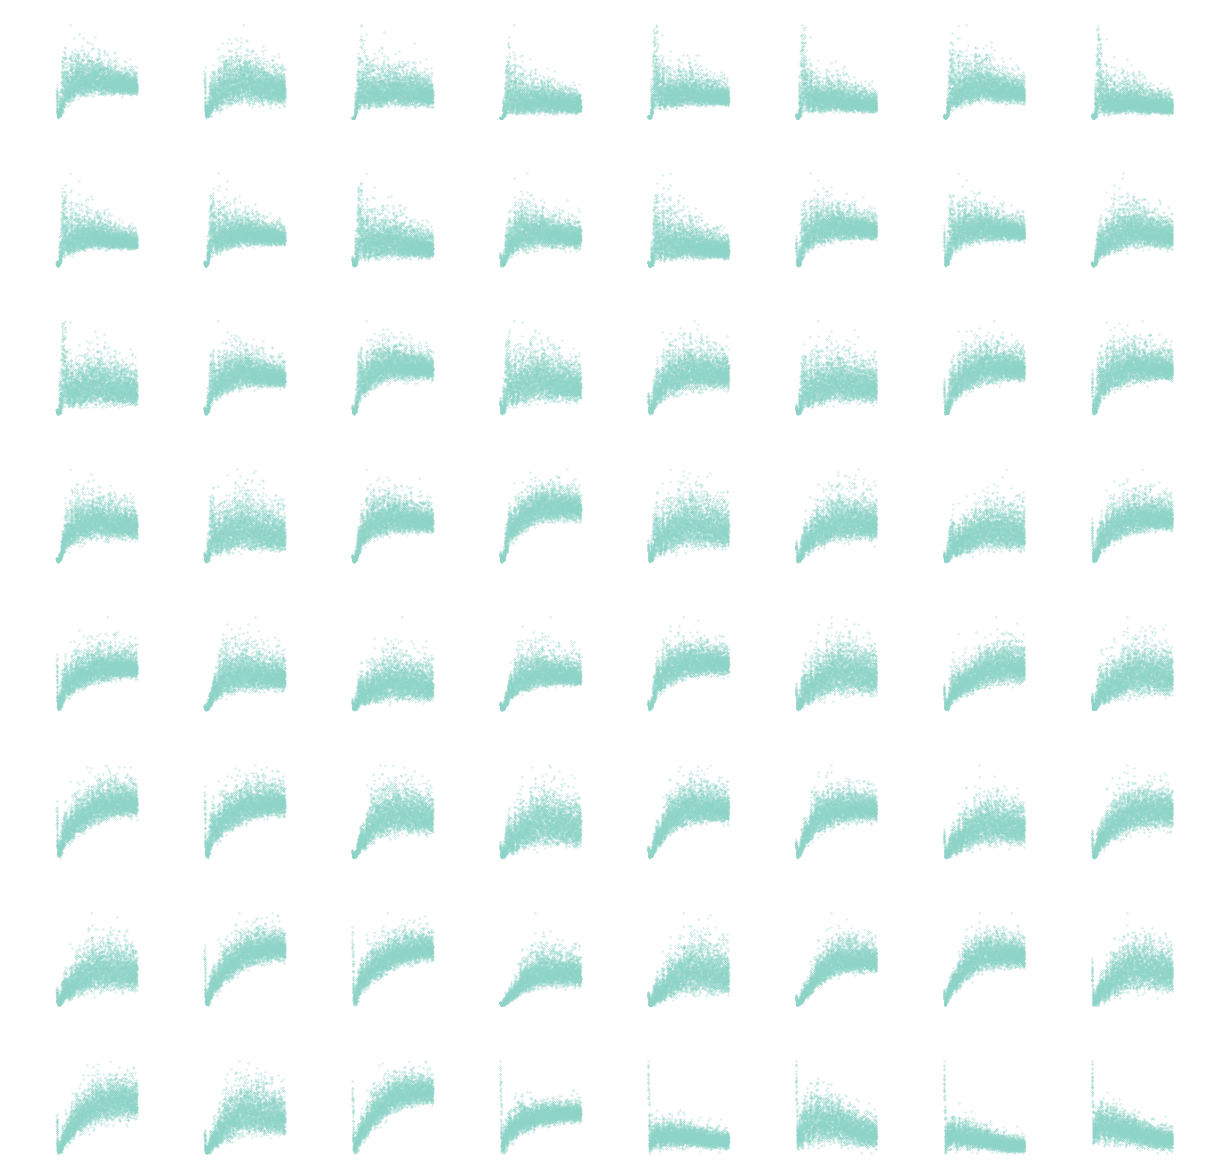

In [ ]:
def plot(k:str):
    plt.figure(figsize=(6, 4), frameon=False)
    plt.plot(history.__getattribute__(k), '.', alpha=.8, ms=1)
    plt.title(k.replace('_', ' ').capitalize())
    plt.show()

for k in history.__annotations__:
    if k != 'gradient_norm':
        plot(k)

rows = round(len(clean_dict)**.5)
dm = divmod(len(clean_dict), rows)
cols = dm[0]+1 if dm[1] != 0 else dm[0]

fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
fig.frameon = False
fig.tight_layout(pad=1.2)
for i, (ax, (k, v)) in enumerate(zip(axes.flat, clean_dict.items())):
    ax.plot(v, '.', ms=.5)
    if k.endswith('.weight'): k = k.replace('.weight', '.w')
    elif k.endswith('.bias'): k = k.replace('bias', '.b')
    ax.set_title(k, y=.96, fontsize=6)
    ax.axis('off')

In [ ]:
# TODO: Do negative mining
# TODO: Do weight visualization
# TODO: Add more data augmentation types
# TODO: Figure out Why TF layer norms have grad?